In [2]:
!unzip ./drive/MyDrive/traindata.zip > /dev/null

In [4]:
!mkdir train test

In [5]:
!mkdir train/panvel train/amravati train/sri\ city test/sri\ city

In [6]:
!cp -r ./data/amravati/images_masked ./train/amravati/

In [7]:
!cp -r ./data/amravati/masks ./train/amravati/

In [8]:
!cp -r ./data/panvel/images_masked ./train/panvel/
!cp -r ./data/panvel/masks ./train/panvel/

In [9]:
!cp -r ./data/sri\ city/images_masked ./test/sri\ city/
!cp -r ./data/sri\ city/masks ./test/sri\ city/

In [10]:
!mkdir cropped

In [11]:
!mkdir cropped/train cropped/test

In [12]:
import os
import os.path
import tifffile as tiff
import numpy as np

from skimage import io
import matplotlib.pyplot as plt

In [13]:
import random
def transform(img, mask):
  transformation_type = random.randint(0,6)

  if (transformation_type == 0):
    img = np.rot90(img, 1)
    mask = np.rot90(mask,1)
  elif (transformation_type == 1):
    img = np.rot90(img, 2)
    mask = np.rot90(mask,2)
  elif (transformation_type == 2):
    img = np.rot90(img, 3)
    mask = np.rot90(mask,3)
  elif (transformation_type == 3):
    img = img.transpose((1,0,2))
    mask = mask.transpose((1,0,2))
  elif (transformation_type == 4):
    img = img[::-1, :, :]
    mask = mask[::-1, :, :]
  elif (transformation_type == 5):
    img = img[:, ::-1, :]
    mask = mask[:, ::-1, :]
  return img,mask

In [30]:
def cropped_data(path):
  img_path = os.path.join(path,'images_masked')
  img_ids = os.listdir(img_path)
  
  mask_path = os.path.join(path,'masks')

  for id in img_ids:
    im_path = os.path.join(img_path,id)
    img = tiff.imread(im_path)

    
    msk_path = os.path.join(mask_path,id)
    mask = tiff.imread(msk_path)
    mask = mask.reshape(mask.shape[:2]+(1,))

    hf_height = img.shape[0]//2
    img_0 = img[:hf_height,:,:]
    mask_0 = mask[:hf_height,:,:]  

    img_1 = img[hf_height:,:,:]
    mask_1 = mask[hf_height:,:,:]

    img_0_transform, mask_0_transform =  transform(img_0,mask_0)

    shape= img_0.shape[0]+img_0_transform.shape[0],img.shape[1],img.shape[2]

 
    img_new= np.zeros(shape,dtype=np.uint8)
    img_new[:hf_height,:,:]=img_0
    #print(img_new[hf_height:,:,:].shape,img_new.shape,shape)
    img_new[hf_height:,:,:]=img_1

    mask_new= np.zeros(shape,dtype=np.uint8)
    mask_new[:hf_height,:,:]=mask_0
    mask_new[hf_height:,:,:]=mask_1


    f, axarr = plt.subplots(2,2,figsize=(25, 25))
    plt.sca(axarr[0][0])
    plt.imshow(img_new)

    mask_new = mask_new.reshape(mask_new.shape[:2])
    plt.sca(axarr[0][1])
    plt.imshow(mask_new)

    plt.sca(axarr[1][0])
    plt.imshow(img)

    mask = mask.reshape(mask.shape[:2])
    plt.sca(axarr[1][1])
    plt.imshow(mask)


  return 

ValueError: ignored

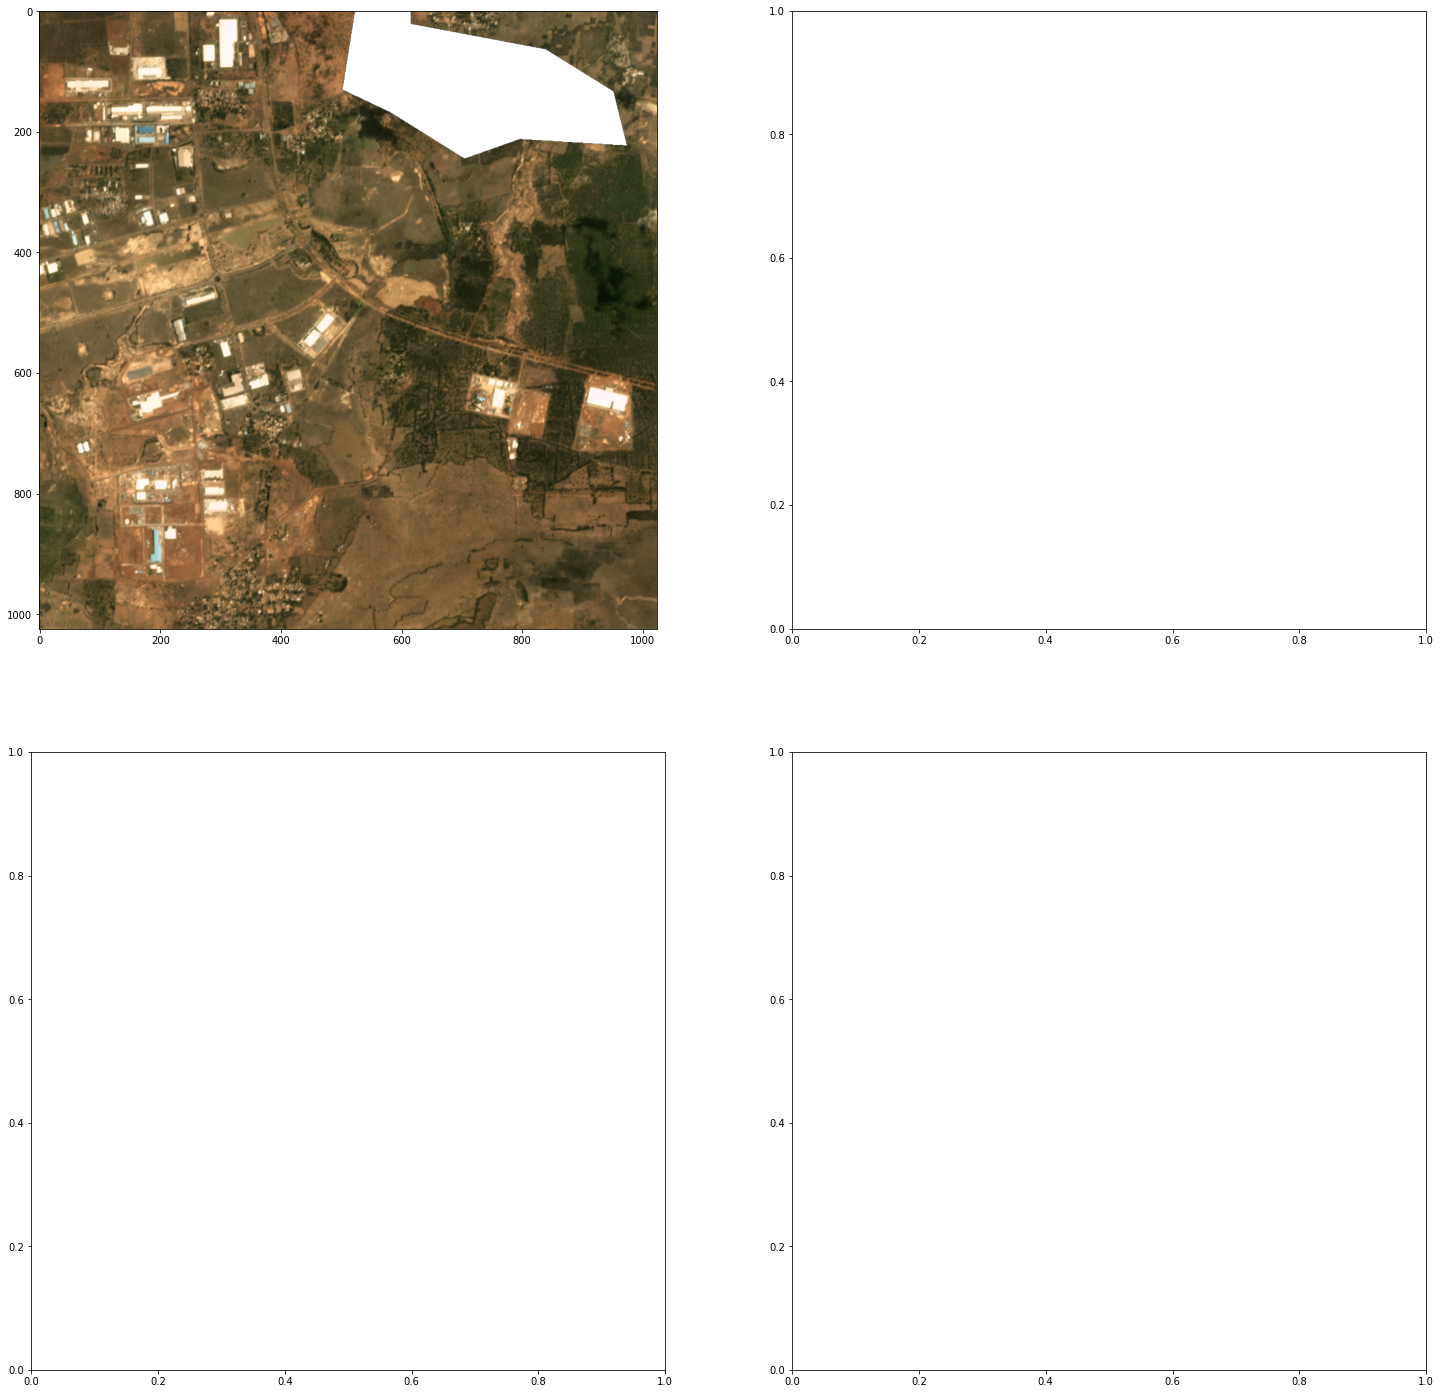

In [31]:
cropped_data("test/sri city")